In [2]:
!pip install tqdm

import urllib.request
import zipfile
import os
from tqdm import tqdm

# Function to download a file with a progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#output = "glove.6B.zip"

# Download the GloVe embeddings with a progress bar
#with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
    #urllib.request.urlretrieve(url, filename=output, reporthook=t.update_to)


# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
    #zip_ref.extractall()

# Ensure gensim is installed
!pip install gensim

# Import KeyedVectors from gensim and load the word vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   - -------------------------------------- 0.8/24.0 MB 4.8 MB/s eta 0:00:05
   --- ------------------------------------ 2.1/24.0 MB 5.3 MB/s eta 0:00:05
   ----- ---------------------------------- 3.4/24.0 MB 5.8 MB/s eta 0:00:04
   -------- ------------------------------- 5.0/24.0 MB 6.2 MB/s eta 0:00:04
   ---------- ----------------------------- 6.3/24.0 MB 6.2 MB/s eta 0:00:03
   ------------ --------------------------- 7.3/24.0 MB 6.1 MB/s eta 0:00:03
   ------------- -------------------------- 8.4/24.0 MB 5.7 MB/s eta 0:00:03
   --------------- ------------------------ 9.4/24.0 MB 5.6 MB/s eta 0:00:03
   ----------------- ---------------------- 10.7/24.0 MB 5.6 MB/s eta 0:00:03
   -------------------- ------------------- 12.1/24.0 MB 5.8 MB/s eta 0:00:03
   ---------------------- ----------------- 13.6/24.0 MB 5.9 MB/s eta 0:00:02
   ------------------------ --------------- 14.7/24.0 MB 5.9 MB/s eta 0:00:02
  

In [16]:
#!pip install torch torch-geometric
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
torch.manual_seed(42)

In [53]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    #pca = PCA(n_components=pca_components)
    #reduced_features = pca.fit_transform(features)  
    #x = torch.tensor(reduced_features, dtype=torch.float32) 
    x = torch.stack(features) 

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)

def calculate_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(labels),
        y = labels)
   
    return torch.tensor(class_weights, dtype=torch.float)
   


class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250, class_weights=None, num_classes = 2):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)

  num_node_features = next(iter(train_dataloader)).x.size(1)

  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  if class_weights is not None:
      class_weights = class_weights.to(device) 
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
  for epoch in range(epoches):
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = loss_fn(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, stage_labels=None, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all, display_labels=stage_labels)
    return logits_all, pred_all, results, disp

def calc_metrics(actual_labels, pred_vals, display_labels=None, print_results=True):
    results = {
        'accuracy': accuracy_score(actual_labels, pred_vals),
        'f1': f1_score(actual_labels, pred_vals, average='macro'),
        'precision': precision_score(actual_labels, pred_vals, average='macro'),
        'recall': recall_score(actual_labels, pred_vals, average='macro')
    }

    cm = confusion_matrix(actual_labels, pred_vals)

    # Get only the unique classes present in the actual predictions
    unique_classes = np.unique(np.concatenate([actual_labels, pred_vals]))  
    if display_labels is None:
        display_labels = [str(label) for label in unique_classes]  # Ensure matching labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    if print_results:
        for metric, value in results.items():
            print(f'{metric}: {value:.3f}')
        disp.plot()
        plt.show()

    return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = features.shape[1]
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

        Stage 1 training set: 50 samples; label count: Counter({0: 44, 1: 6}),
        Stage 2 training set: 50 samples; label count: Counter({0: 45, 1: 5}),
        train set for meta model: 25 samples; label count: Counter({0: 22, 1: 3}),
        dev set for meta model: 32 samples; label count: Counter({0: 30, 1: 2})
----------- Task: CTD -----------
Training base model for Dementia Classification...
Setting batch size to  50
Epoch 0, Loss: 0.75081
Epoch 50, Loss: 0.08749
Epoch 100, Loss: 0.00023
Epoch 150, Loss: 0.00013
Epoch 200, Loss: 0.00009
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.840
f1: 0.457
precision: 0.438
recall: 0.477


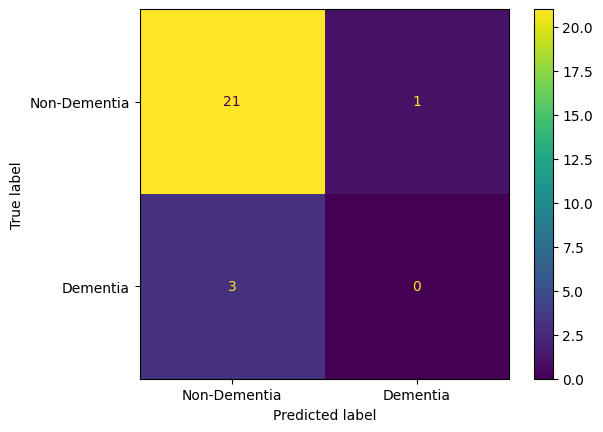

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.875
f1: 0.467
precision: 0.467
recall: 0.467


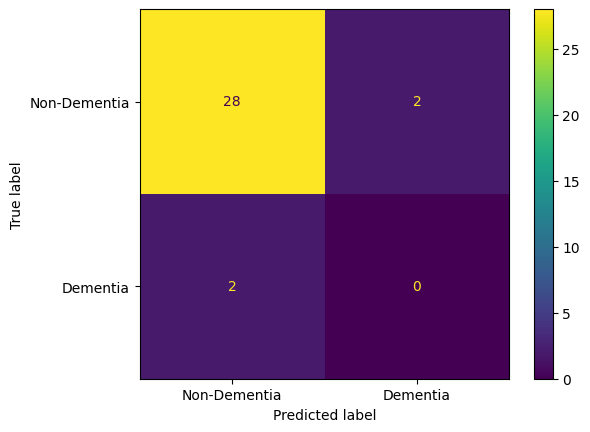

Validating Stage 1 model on Stage 2 training data...
Setting batch size to  50
accuracy: 0.840
f1: 0.457
precision: 0.447
recall: 0.467


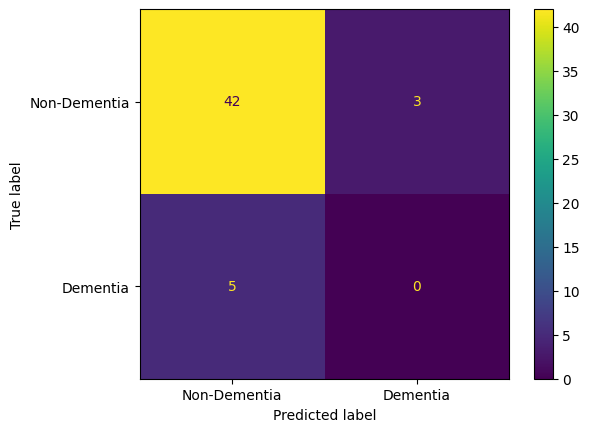

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  42
Epoch 0, Loss: 0.70399
Epoch 50, Loss: 0.07144
Epoch 100, Loss: 0.00077
Epoch 150, Loss: 0.00038
Epoch 200, Loss: 0.00024
Validating Stage 2 model on ensemble training set...
Setting batch size to  21
accuracy: 0.571
f1: 0.533
precision: 0.550
recall: 0.542


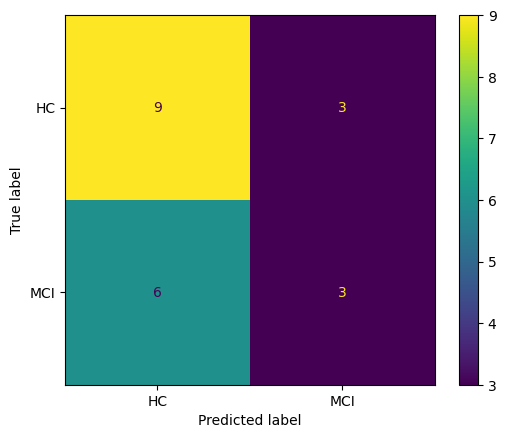

Validating Stage 2 model on meta model dev set...
Setting batch size to  28
accuracy: 0.714
f1: 0.708
precision: 0.714
recall: 0.733


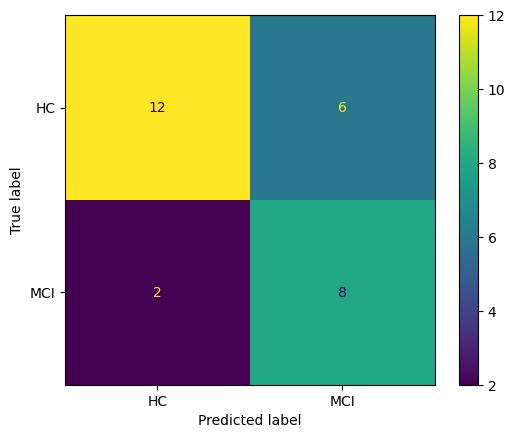

['HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'MCI', 'HC', 'HC', 'HC', 'HC', 'Dementia', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'MCI', 'HC', 'MCI', 'HC']
Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.00      0.00      0.00         0
         MCI       0.90      0.86      0.88        22
    Dementia       0.33      0.33      0.33         3

    accuracy                           0.80        25
   macro avg       0.41      0.40      0.41        25
weighted avg       0.84      0.80      0.82        25

----------- Task: SFT -----------


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Training base model for Dementia Classification...
Setting batch size to  50
Epoch 0, Loss: 0.77086
Epoch 50, Loss: 0.05830
Epoch 100, Loss: 0.00011
Epoch 150, Loss: 0.00007
Epoch 200, Loss: 0.00005
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.840
f1: 0.457
precision: 0.438
recall: 0.477


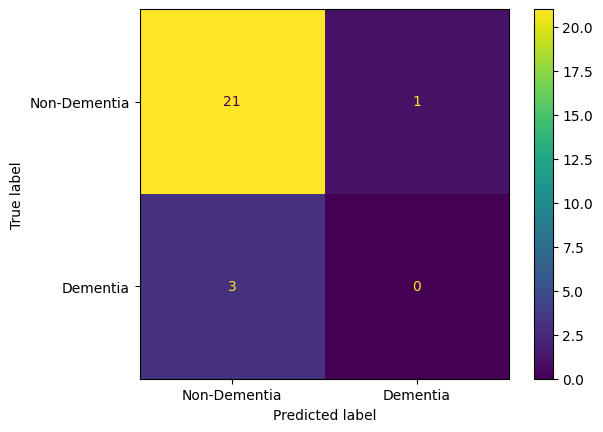

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.875
f1: 0.467
precision: 0.467
recall: 0.467


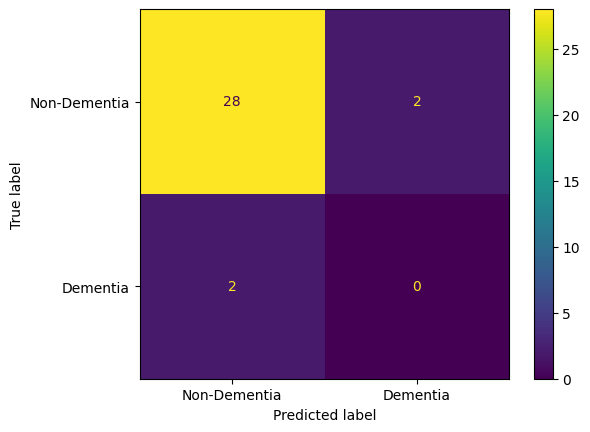

Validating Stage 1 model on Stage 2 training data...
Setting batch size to  50
accuracy: 0.900
f1: 0.474
precision: 0.450
recall: 0.500


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


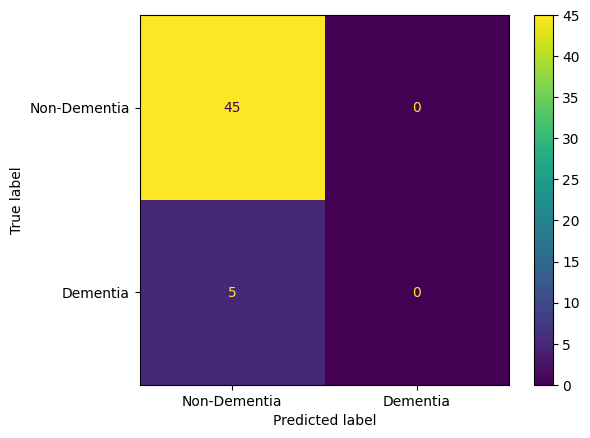

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  45
Epoch 0, Loss: 0.70714
Epoch 50, Loss: 0.00276
Epoch 100, Loss: 0.00020
Epoch 150, Loss: 0.00014
Epoch 200, Loss: 0.00010
Validating Stage 2 model on ensemble training set...
Setting batch size to  21
accuracy: 0.476
f1: 0.430
precision: 0.429
recall: 0.433


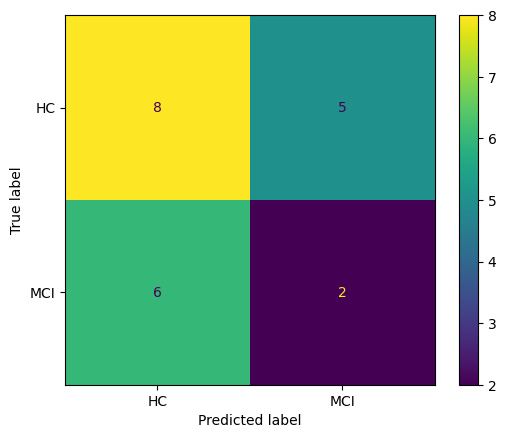

Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.704
f1: 0.693
precision: 0.692
recall: 0.703


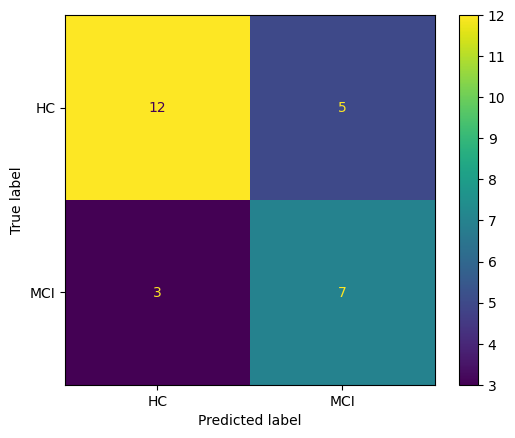

['HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'Dementia', 'HC', 'HC', 'HC', 'HC', 'HC']
Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.00      0.00      0.00         0
         MCI       0.88      0.95      0.91        22
    Dementia       0.00      0.00      0.00         3

    accuracy                           0.84        25
   macro avg       0.29      0.32      0.30        25
weighted avg       0.77      0.84      0.80        25

----------- Task: PFT -----------


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Training base model for Dementia Classification...
Setting batch size to  50
Epoch 0, Loss: 0.72561
Epoch 50, Loss: 0.00079
Epoch 100, Loss: 0.00006
Epoch 150, Loss: 0.00004
Epoch 200, Loss: 0.00003
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.880
f1: 0.468
precision: 0.440
recall: 0.500


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


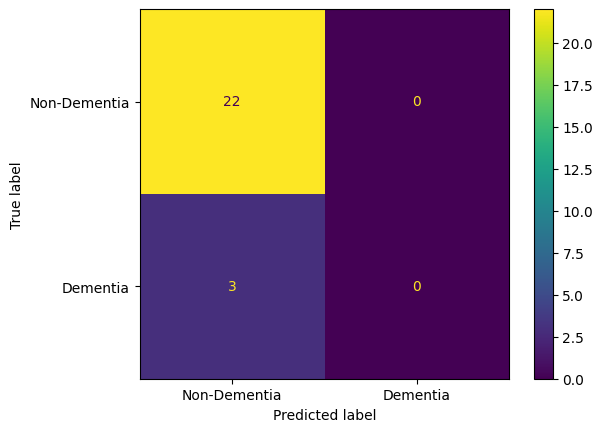

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.906
f1: 0.475
precision: 0.468
recall: 0.483


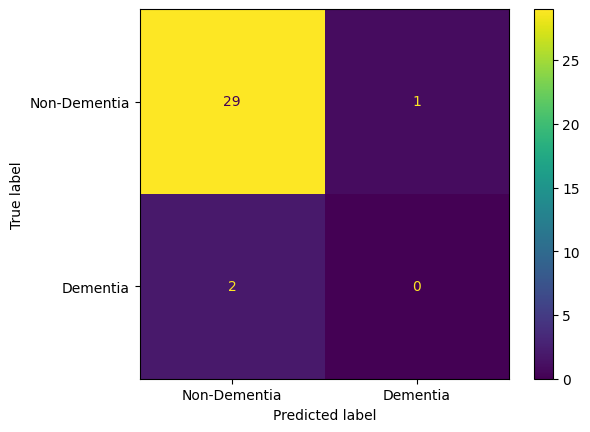

Validating Stage 1 model on Stage 2 training data...
Setting batch size to  50
accuracy: 0.880
f1: 0.468
precision: 0.449
recall: 0.489


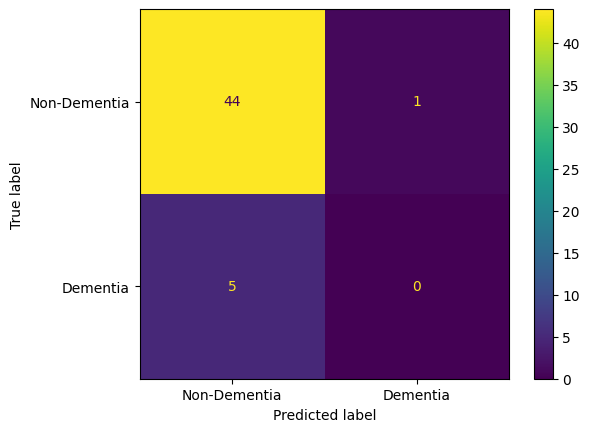

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  44
Epoch 0, Loss: 0.69402
Epoch 50, Loss: 0.00019
Epoch 100, Loss: 0.00004
Epoch 150, Loss: 0.00003
Epoch 200, Loss: 0.00002
Validating Stage 2 model on ensemble training set...
Setting batch size to  22
accuracy: 0.545
f1: 0.476
precision: 0.494
recall: 0.496


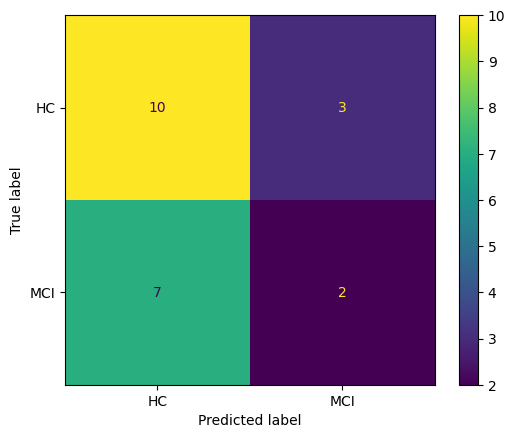

Validating Stage 2 model on meta model dev set...
Setting batch size to  28
accuracy: 0.679
f1: 0.657
precision: 0.656
recall: 0.675


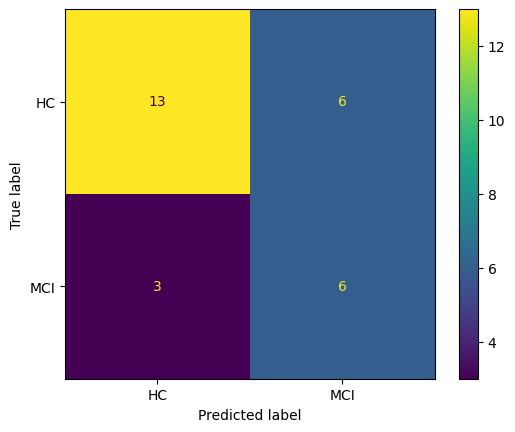

['HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC']
Overall Performance on Ensemble Training Dataset:


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    "mode": "cascaded",  # or "non-cascaded"
    "tasks": ['CTD', 'SFT', 'PFT'],
    "num_folds": 5,
    "random_state": 42,
    "label_mapping_stage1": {'HC': 0, 'MCI': 0, 'Dementia': 1},
    "label_mapping_stage2": {'HC': 0, 'MCI': 1},
    "label_mapping_non_cascaded": {'HC': 0, 'MCI': 1, 'Dementia': 2}
}


if config['mode'] == 'cascaded':
    metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
    metadata = metadata.sample(frac=1, random_state=config['random_state'], ignore_index=False)
    metadata['diagnosis_coded_stage1'] = metadata['diagnosis'].map(config['label_mapping_stage1'])
    metadata['diagnosis_coded_stage2'] = metadata['diagnosis'].map(config['label_mapping_stage2']).fillna(-1).astype(int)
    df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
    id_traindev, label_traindev_stage1 = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded_stage1']
    
    skf = StratifiedKFold(n_splits=config["num_folds"], shuffle=True, random_state=config['random_state'])
    F1scores_stage1 = defaultdict(list)
    F1scores_stage2 = defaultdict(list) 

    for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev_stage1)):
        print(f"Fold {fold_index}:")
        base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev_stage1[train_index],
                                                            stratify=label_traindev_stage1[train_index],
                                                            test_size=0.2)
        
        base_train_id_stage1, base_train_id_stage2, base_train_label_stage1, base_train_label_stage2 = train_test_split(base_train_id, base_train_label,
                                                            stratify= base_train_label,
                                                            test_size=0.5)
        print(f'''
        Stage 1 training set: {len(base_train_label_stage1)} samples; label count: {Counter(base_train_label_stage1)},
        Stage 2 training set: {len(base_train_label_stage2)} samples; label count: {Counter(base_train_label_stage2)},
        train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
        dev set for meta model: {len(label_traindev_stage1[dev_index])} samples; label count: {Counter(label_traindev_stage1[dev_index])}''')

        logits_for_ensemble_training = []
        pred_for_ensemble_training = []

        logits_for_ensemble_validation = []
        pred_for_ensemble_validation = []

        class_weights_stage1 = calculate_class_weights(base_train_label_stage1)

        for task in config['tasks']:
            print(f'----------- Task: {task} -----------')
            transcript_folder = os.path.join("transcripts_outputFiles", f"{task}_outputFiles")
            if not os.path.exists(transcript_folder):
                os.makedirs(transcript_folder)
            base_train_datalist_stage1 = get_datalist(base_train_id_stage1, base_train_label_stage1, transcript_folder)
            ensemble_train_datalist = get_datalist(ensemble_train_id, ensemble_train_label, transcript_folder)
            ensemble_dev_datalist = get_datalist(id_traindev[dev_index], label_traindev_stage1[dev_index], transcript_folder)
            
            print('Training base model for Dementia Classification...')
            trained_gnn_stage1 = train_gnn(base_train_datalist_stage1)
            
            print('Validating on meta model train set...')
            task_logits_ensemble_training, task_pred_ensemble_training, results_dict, _ = eval_gnn(trained_gnn_stage1, ensemble_train_datalist, stage_labels= ['Non-Dementia', 'Dementia'], print_results=False)
            F1scores_stage1[task].append(results_dict["f1"])
            
            print('Validating on meta model dev set...')
            task_logits_ensemble_validation, task_pred_ensemble_validation, results_dict, _ = eval_gnn(trained_gnn_stage1, ensemble_dev_datalist, stage_labels= ['Non-Dementia', 'Dementia'], print_results=False)
            F1scores_stage1[task].append(results_dict["f1"])

            print('Validating Stage 1 model on Stage 2 training data...')
            task_logits_stage2_training, task_pred_stage2_training, results_dict, _ = eval_gnn(
                trained_gnn_stage1, get_datalist(base_train_id_stage2, base_train_label_stage2, transcript_folder),
                stage_labels=['Non-Dementia', 'Dementia'], print_results=False
            )
            F1scores_stage1[task].append(results_dict["f1"])

            # Filter Stage 2 training data for healthy participants
            healthy_train_indices = [i for i, pred in enumerate(task_pred_stage2_training) if pred == 0]
            valid_healthy_train = [
                (id, df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0])
                for id in base_train_id_stage2.iloc[healthy_train_indices]
                if df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0] in [0, 1]
            ]

            healthy_train_ids, healthy_train_labels = zip(*valid_healthy_train) if valid_healthy_train else ([], [])
            healthy_train_datalist = get_datalist(healthy_train_ids, healthy_train_labels, transcript_folder)

            # Train Stage 2 model
            print('Training base model for Healthy vs. MCI (Stage 2)...')
            if healthy_train_ids:
                class_weights_stage2 = calculate_class_weights(healthy_train_labels)
                trained_gnn_stage2 = train_gnn(healthy_train_datalist)
            else:
                print("No valid healthy train samples available. Skipping Stage 2 training.")
            
            # Validate Stage 2 model on ensemble training set
            
            print('Validating Stage 2 model on ensemble training set...')
            healthy_ensemble_train_indices = [i for i, pred in enumerate(task_pred_ensemble_training) if pred == 0]
            valid_healthy_ensemble_train = [
                (id, df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0])
                for id in ensemble_train_id.iloc[healthy_ensemble_train_indices]
                if df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0] in [0, 1]
            ]

            healthy_ensemble_train_ids, healthy_ensemble_train_labels = zip(*valid_healthy_ensemble_train) if valid_healthy_ensemble_train else ([], [])
            healthy_ensemble_train_datalist = get_datalist(healthy_ensemble_train_ids, healthy_ensemble_train_labels, transcript_folder)

            _, _, results_dict, _ = eval_gnn(trained_gnn_stage2, healthy_ensemble_train_datalist, stage_labels=['HC', 'MCI'])
            F1scores_stage2[task].append(results_dict["f1"])

            # Validate Stage 2 model on ensemble validation set

            print('Validating Stage 2 model on meta model dev set...')
            healthy_dev_indices = [i for i, pred in enumerate(task_pred_ensemble_validation) if pred == 0]
            valid_healthy_dev = [
                (id, df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0])
                for id in id_traindev.iloc[dev_index].iloc[healthy_dev_indices]
                if df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0] in [0, 1]
            ]

            healthy_dev_ids, healthy_dev_labels = zip(*valid_healthy_dev) if valid_healthy_dev else ([], [])
            healthy_dev_datalist = get_datalist(healthy_dev_ids, healthy_dev_labels, transcript_folder)

            _, _, results_dict, _ = eval_gnn(trained_gnn_stage2, healthy_dev_datalist, stage_labels=['HC', 'MCI'])
            F1scores_stage2[task].append(results_dict["f1"])

            # note - still working on how to calculate combined performance

            # Calculate overall performance on ensemble training set
            combined_predictions_ensemble_train = []

            for i in range(len(ensemble_train_id)):
                if i in healthy_ensemble_train_indices:
                    index_in_stage2 = healthy_ensemble_train_indices.index(i)
                    if task_pred_stage2_training[index_in_stage2] == 0:
                        combined_predictions_ensemble_train.append('HC') 
                    else:
                        combined_predictions_ensemble_train.append('MCI')
                else:
                    combined_predictions_ensemble_train.append('Dementia')

            print(combined_predictions_ensemble_train)        

            actual_labels_ensemble_train = ensemble_train_label.map({0: 'HC', 1: 'MCI', 2: 'Dementia'})

            print('Overall Performance on Ensemble Training Dataset:')
            print(classification_report(actual_labels_ensemble_train, combined_predictions_ensemble_train, target_names=['HC', 'MCI', 'Dementia']))


    mean_f1_stage1 = {}
    mean_f1_stage2 = {}
    all_f1_scores = {}

    for key in F1scores_stage1.keys():
        mean_f1_stage1[key] = sum(F1scores_stage1[key]) / len(F1scores_stage1[key])
        mean_f1_stage2[key] = sum(F1scores_stage2[key]) / len(F1scores_stage2[key])
        all_f1_scores[key] = F1scores_stage1[key] + F1scores_stage2[key]
        mean_f1_overall = sum(all_f1_scores[key]) / len(all_f1_scores[key]) if all_f1_scores[key] else 0

    for key, values in mean_f1_stage1.items():
        print(f"Mean F1 Score for {key} task (Stage 1 - Dementia vs. Non-Dementia): {values:.3f}")

    for key, values in mean_f1_stage2.items():
        print(f"Mean F1 Score for {key} task (Stage 2 - Healthy vs. MCI): {values:.3f}")        